### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from scipy.stats import t
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)

# Pre-processing initial datases

In this section, we perform two steps. 

1. load and combine data.

Data is initially collected from different excel files. For instance, these file `'2013_1.xlsx', '2013_2.xlsx', '2013_3.xlsx', '2013_4.xlsx'` will be combined to form one combined data for the year 2013, similarly we do the same for 2020 data. The function to perform this combination is `load_and_combine_data(file_list, year_label)` that takes in list of files that need to be combined and the year it belongs to.


2. map categories

In the step, we map different numeric values to their respective categories. For instance, these numeric values `[1, 2005, 2, 5007]` will be mapped to `positives` category and these values `[3, 1004, 2006, 4006, 6008]` will be mapped to `nagatives` category and so on.

After performing these two steps, the files will be saved as `'preprocessed_2013.xlsx'` and `'preprocessed_2020.xlsx'` 

In [2]:
import pandas as pd
import os

# Step 1: Read all Excel files into one dataframe
DATA_FILES_2013 = ['2013_1.xlsx', '2013_2.xlsx', '2013_3.xlsx', '2013_4.xlsx']  # Replace with your actual file paths
DATA_FILES_2020 = ['2020_1.xlsx', '2020_2.xlsx', '2020_3.xlsx', '2020_4.xlsx']  # Replace with your actual file paths

OUTPUT_PATH_2013 = 'preprocessed_2013.xlsx'
OUTPUT_PATH_2020 = 'preprocessed_2020.xlsx'



# Step 2: Add a new Category2 column based on the current Category column
def map_category(category):
    positives = [1, 2005, 2, 5007]
    automatic = [1001, 1002, 1003, 2004, 3006, 4005, 5006, 6007, 7008]
    negatives = [3, 1004, 2006, 4006, 6008]

    if pd.isna(category) or category == '<Empty>':
        return 'empty'
    elif category in positives:
        return 'positives'
    elif category in automatic:
        return 'automatic'
    elif category in negatives:
        return 'negatives'
    else:
        return 'unknown'  # Or handle other categories as needed


    
    
# --- Function to Load and Combine Multiple Files ---
def load_and_combine_data(file_list, year_label):
    """Loads data from a list of files and concatenates them."""
    all_data = []
    print(f"Loading files for {year_label}:")
    for file_path in file_list:
        print(f"  - Reading: {file_path}")
        if not os.path.exists(file_path):
            print(f"    Warning: File not found at {file_path}. Skipping.")
            continue
        try:
            df_part = pd.read_excel(file_path)
            print(f"    Loaded shape: {df_part.shape}")
            all_data.append(df_part)
        except Exception as e:
            print(f"    Error loading file {file_path}: {e}. Skipping.")
            continue

    if not all_data:
        print(f"Error: No data successfully loaded for {year_label}. Check file paths and formats.")
        return None

    # Concatenate all parts
    df_combined = pd.concat(all_data, ignore_index=True)
    print(f"Combined shape for {year_label}: {df_combined.shape}")
    return df_combined



df_combined_2013 = load_and_combine_data(DATA_FILES_2013, "2013")
df_combined_2020 = load_and_combine_data(DATA_FILES_2020, "2020")


df_combined_2013['Category2'] = df_combined_2013['Category'].apply(map_category)
df_combined_2020['Category2'] = df_combined_2020['Category'].apply(map_category)

df_combined_2013.to_excel(OUTPUT_PATH_2013, index=False)
df_combined_2020.to_excel(OUTPUT_PATH_2020, index=False)

TOTAL_2013_NOTES_IN_INITIAL_DATABASES = len(df_combined_2013)
TOTAL_2020_NOTES_IN_INITIAL_DATABASES = len(df_combined_2020)

print('-----------------------------------------------------------')
print(f'TOTAL_2013_NOTES_IN_INITIAL_DATABASES : {TOTAL_2013_NOTES_IN_INITIAL_DATABASES} \nTOTAL_2020_NOTES_IN_INITIAL_DATABASES: {TOTAL_2020_NOTES_IN_INITIAL_DATABASES}')

Loading files for 2013:
  - Reading: 2013_1.xlsx
    Loaded shape: (100000, 3)
  - Reading: 2013_2.xlsx
    Loaded shape: (100000, 3)
  - Reading: 2013_3.xlsx
    Loaded shape: (100000, 3)
  - Reading: 2013_4.xlsx
    Loaded shape: (62525, 3)
Combined shape for 2013: (362525, 3)
Loading files for 2020:
  - Reading: 2020_1.xlsx
    Loaded shape: (120000, 3)
  - Reading: 2020_2.xlsx
    Loaded shape: (120000, 3)
  - Reading: 2020_3.xlsx
    Loaded shape: (120000, 3)
  - Reading: 2020_4.xlsx
    Loaded shape: (37956, 3)
Combined shape for 2020: (397956, 3)
-----------------------------------------------------------
TOTAL_2013_NOTES_IN_INITIAL_DATABASES : 362525 
TOTAL_2020_NOTES_IN_INITIAL_DATABASES: 397956


# Statistical comparison of the proportion of positive cases between 2013 and 2020 dataset

This Statistical comparison involves calculating the proportion (the number of positive cases divided by the total number of cases) for each dataset i.e 2013 and 2020 dataset and then applying statistical methods to assess whether the difference observed in these proportions is likely due to random variation (statistical noise) or if it reflects a true, significant difference in the populations represented by the datasets.

## Load 2013 data


In [3]:
# Load 2013 data (training set)
df_2013 = pd.read_excel(r"./preprocessed_2013.xlsx")

# Excluding notes classified as "automatic"
df_2013 = df_2013[df_2013.Category2.isin(['empty', 'automatic']) == False]
df_2013['Score'] = df_2013['Proc1SVM']

df_2013_sorted = df_2013.sort_values(by=['Score'], ascending=False)
df_2013_sorted['CleanedSeqN'] = np.arange(len(df_2013_sorted))



## Load 2020 data

In [4]:
# Load 2020 data (test set)
df_2020 = pd.read_excel(r"./preprocessed_2020.xlsx")

# Excluding notes classified as "automatic"
df_2020 = df_2020[df_2020.Category2.isin(['empty', 'automatic']) == False]
df_2020['Score'] = df_2020['Proc1SVM']
df_2020_sorted = df_2020.sort_values(by=['Score'], ascending=False)
df_2020_sorted['CleanedSeqN'] = np.arange(len(df_2020_sorted))

## Combine manually reviewed data

In [5]:
mr_2013 = df_2013.drop(['Category', 'Proc1SVM', 'Score'], inplace=False, axis=1)
mr_2013['year'] = '2013'

mr_2020 = df_2020.drop(['Category', 'Proc1SVM', 'Score'], inplace=False, axis=1)
mr_2020['year'] = '2020'

mr_combined = pd.concat([mr_2013, mr_2020])
mr_combined = mr_combined.rename(columns={'Category2':'label'})
mr_combined


,ED_ENC_NUM,label,year
12,13,negatives,2013
22,23,negatives,2013
23,24,negatives,2013
43,44,negatives,2013
48,49,negatives,2013
...,...,...,...
397235,397236,negatives,2020
397277,397278,negatives,2020
397344,397345,negatives,2020
397447,397448,negatives,2020


# Count positives and negatives per year

In [6]:
# Count positives and negatives per year
counts = mr_combined.groupby(['year', 'label']).size().unstack(fill_value=0)

# Extract counts for 2013 and 2020
positives_2013 = counts.loc['2013', 'positives'] if 'positives' in counts.columns else 0
negatives_2013 = counts.loc['2013', 'negatives']
total_2013 = positives_2013 + negatives_2013

positives_2020 = counts.loc['2020', 'positives'] if 'positives' in counts.columns else 0
negatives_2020 = counts.loc['2020', 'negatives']
total_2020 = positives_2020 + negatives_2020

## Find Z-statistic, P value, Proportions, Difference in proportions, 95% confidence interval


### 1. **Z-statistic**
The Z-statistic is a measure of how far a data point is from the mean of a distribution in terms of standard deviations. In hypothesis testing, the Z-statistic quantifies the difference between observed sample data and the null hypothesis, normalized by the standard error. It is commonly used in tests like the two-proportion Z-test or Z-tests for means.

- **Usage in Proportions**: For comparing proportions, the Z-statistic evaluates whether the difference between two proportions is statistically significant.
- **Interpretation**: A higher absolute value of the Z-statistic indicates a larger deviation from the null hypothesis. For example:
  - A Z-statistic of 0 implies no difference.
  - Positive or negative values indicate the direction of the deviation.

---

### 2. **P-value**
The P-value is the probability of obtaining results as extreme as, or more extreme than, those observed, assuming the null hypothesis is true. It helps determine the statistical significance of the test results.

- **Usage in Proportions**: A small P-value (e.g., < 0.05) suggests that the observed difference in proportions is unlikely to be due to random chance, leading to rejection of the null hypothesis.
- **Interpretation**:
  - A **small P-value** (e.g., < 0.05): Strong evidence against the null hypothesis.
  - A **large P-value**: Insufficient evidence to reject the null hypothesis.

---

### 3. **Proportions**
Proportions represent a fraction or percentage of a total that exhibits a particular characteristic or outcome. In statistical analysis, proportions are used to summarize categorical data.

- **Formula**:  
$$
  \text{Proportion} = \frac{\text{Number of Positive Cases}}{\text{Total Number of Cases}}
$$
- **Example**: If 30 out of 100 patients tested positive in 2013, the proportion is 30/100 = 0.3 or 30%.

---

### 4. **Difference in Proportions**
The difference in proportions measures the disparity between two groups’ proportions and is used to assess whether there is a significant difference between them.

- **Formula**:  
$$
  \text{Difference in Proportions} = \text{Proportion}_1 - \text{Proportion}_2
$$
- **Usage**: For instance, comparing the proportion of positive cases in 2013 to 2020, the difference indicates whether one group has a higher or lower rate than the other.
- **Statistical Test**: A two-proportion Z-test is often used to assess whether the observed difference is statistically significant.

---

### 5. **95% Confidence Interval**
A 95% confidence interval (CI) provides a range of values within which the true population parameter (e.g., proportion or difference in proportions) is likely to fall, with 95% confidence.

- **Meaning**: If the test were repeated many times, 95% of the calculated confidence intervals would contain the true population parameter.
- **Formula** (for proportions):  
  $$
  \text{CI} = \hat{p} \pm Z_{\alpha/2} \cdot \sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}
  $$
  where $\hat{p}$ is the sample proportion, $Z_{\alpha/2}$ is the Z-critical value, and $n$ is the sample size.
- **Usage in Differences**: For comparing proportions, the CI estimates the range for the difference between two proportions.
- **Interpretation**: 
  - If the CI for a difference in proportions includes 0, it indicates no significant difference.
  - A CI entirely above or below 0 suggests a significant difference.

---
These metrics collectively help evaluate statistical significance and the reliability of observed differences in data.

In [7]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Define counts
count = [positives_2013, positives_2020]  # Number of successes (positives)
nobs = [total_2013, total_2020]           # Total number of trials

# Perform z-test
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
    print("Conclusion: There is a significant difference in proportions (p < 0.05).\n")
else:
    print("Conclusion: No significant difference in proportions (p ≥ 0.05).\n")
    
    
# Proportions
p_2013 = positives_2013 / total_2013
p_2020 = positives_2020 / total_2020

# Difference in proportions
diff = p_2020 - p_2013

# Standard error for the difference
se = np.sqrt(p_2013 * (1 - p_2013) / total_2013 + p_2020 * (1 - p_2020) / total_2020)

# 95% confidence interval
ci_low = diff - 1.96 * se
ci_high = diff + 1.96 * se

print(f"Proportion (2013): {p_2013:.4f}")
print(f"Proportion (2020): {p_2020:.4f}")
print(f"Difference (2020 - 2013): {diff:.4f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

Z-statistic: 1.3549
P-value: 0.1755
Conclusion: No significant difference in proportions (p ≥ 0.05).

Proportion (2013): 0.0207
Proportion (2020): 0.0179
Difference (2020 - 2013): -0.0027
95% CI: [-0.0066, 0.0011]


## Find Chiq-squared (Optional) 
### **Chi-Squared Test**
The Chi-Squared $\chi^2$ test is a statistical test used to determine if there is a significant association between categorical variables in a contingency table. It evaluates whether the observed frequencies in the table differ significantly from the expected frequencies under the null hypothesis.

In [8]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = [
    [positives_2013, negatives_2013],
    [positives_2020, negatives_2020]
]

# Perform chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table, correction=False)

print(f"Chi-squared statistic: {chi2_stat:.4f}")

Chi-squared statistic: 1.8357


## Result Summary

### No Significant Difference Found

We conducted a two-proportion z-test (equivalent to a chi-square test) to compare the prevalence of positive cases between 2013 and 2020. The results showed no statistically significant difference in proportions:

Test statistic: χ² = 1.8357 (Z = 1.3549)

p-value: 0.1755 (p > 0.05)

Proportions:

2013: 2.07% positives

2020: 1.79% positives

Difference: -0.27% (95% CI: [-0.66%, +0.11%])

Interpretation:

The small observed decline in positive cases (0.27% fewer in 2020) could plausibly be due to random variation, as the confidence interval includes zero and the p-value exceeds the significance threshold. While this suggests stable prevalence of qualifying cases over time, it does not rule out subtler shifts in documentation patterns or model performance drift, which may require further investigation through score distribution analysis or yield modeling.

### Confidence Interval (Non-Significant Result)

Although the chi-square test did not detect a statistically significant difference (χ² = 1.8357, *p = 0.1755*), the confidence interval for the proportion difference (-0.27%, 95% CI: [-0.66%, +0.11%]) provides critical context:

The true difference could range from a 0.66% decrease to a 0.11% increase in positives in 2020.
The interval’s inclusion of zero aligns with the non-significant p-value, but its width highlights uncertainty.
Implications:
While the overall prevalence appears stable, the CI’s range suggests that even minor temporal shifts (e.g., localized changes in documentation) could exist below the threshold of statistical detection. Proactive monitoring via adaptive sampling or stratified analysis (e.g., by clinical subgroups) may still be warranted to mitigate potential drift risks.

# Data Preparation



For each note, we computed the target variable as the positive ratio, defined as the proportion of remaining true positive records below a given score threshold. 

Specifically, for each record, the following values were computed:  

●	positive_ratio_above: Ratio of positives among all higher-ranked records

●	positive_ratio_below: Ratio of positives among lower-ranked records, to be used as the regression target.


In [9]:

def calculate_ratios(df):
    df['positive_ratio_above'] = 0
    df['positive_ratio_below'] = 0
    
    for idx, row in df.iterrows():
        score = row['Score']
        
        # Calculate ratio above
        above = df[df['Score'] > score]
        if len(above) > 0:
            df.at[idx, 'positive_ratio_above'] = len(above[above['Category2'] == 'positives']) / len(above)
        
        # Calculate ratio below
        below = df[df['Score'] < score]
        if len(below) > 0:
            df.at[idx, 'positive_ratio_below'] = len(below[below['Category2'] == 'positives']) / len(df[df['Category2'] == 'positives'])
    
    return df


# Calculate ratios for both datasets
print("Calculating ratios for 2013 data...")
df_2013_processed = calculate_ratios(df_2013_sorted.copy())

print("Calculating ratios for 2020 data...")
df_2020_processed = calculate_ratios(df_2020_sorted.copy())

# Prepare data
X_2013 = df_2013_processed[['Score', 'positive_ratio_above']]
y_2013 = df_2013_processed['positive_ratio_below']

X_2020 = df_2020_processed[['Score', 'positive_ratio_above']]
y_2020 = df_2020_processed['positive_ratio_below']

Calculating ratios for 2013 data...
Calculating ratios for 2020 data...


# Model architectures

It includes four predictive regression models.

1. **LinearRegression**: We use LinearRegression() from sklearn.linear_model <br>

2. **Polynomial Regression**: It was implemented as a pipeline combining PolynomialFeatures(degree = 2) and LinearRegression(). <br>

3. **Support Vector Regression**: It was implemented via a pipeline with StandardScaler() and SVR(kernel='rbf'), using radial basis function (RBF) kernel. Unless otherwise specified, hyperparameters were set to default (C=1.0, epsilon=0.1).<br>

4. **PyTorch Neural Network Regressor**: A lightweight, fully connected feedforward neural network was implemented as a scikit-learn compatible wrapper (PyTorchRegressor). The corresponding model architecture consisted of <br> (i) input layer (1 feature); <br> (ii) hidden layer 1 (32 neurons, ReLU activation); <br> (iii) hidden layer 2 (16 neurons, ReLU activation); and <br> (iv) output layer (1 neuron, linear activation). <br><br> Training was performed using the Adam optimizer (learning_rate = 0.001) and mean squared error loss over 50 epochs with a batch size of 32. 

In [10]:
# Linear Regression
linear_model = LinearRegression()

# Polynomial Regression (degree=2)
poly_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

# Support Vector Regression
svr_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1.0, epsilon=0.1)
)


class PyTorchNN(nn.Module):
    def __init__(self, input_size):
        super(PyTorchNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=5, batch_size=32, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        # Set deterministic seeds before model creation
        torch.manual_seed(42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(42)
            
        # Convert data to PyTorch tensors
        X = self.scaler.fit_transform(X)
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y.values).view(-1, 1)
        
        # Create dataset and dataloader
        dataset = TensorDataset(X_tensor, y_tensor)
        g = torch.Generator().manual_seed(42)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=g)
        
        # Initialize model
        self.model = PyTorchNN(input_size=X.shape[1])
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
        return self
    
    def predict(self, X):
        if self.model is None:
            raise RuntimeError("Model not trained yet")
            
        X = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X)
        
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor)
        
        return predictions.numpy().flatten()
    
    def get_params(self, deep=True):
        return {
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    
# PyTorch Neural Network
nn_model = PyTorchRegressor(epochs=50, batch_size=32, learning_rate=0.001)

# Collection of all four models
models = {
    'Linear Regression': linear_model,
    'Polynomial Regression': poly_model,
    'Support Vector Regression': svr_model,
    'PyTorch Neural Network': nn_model
}

# Training and evaluation protocol

Statistics for training and test data. The following code blocks include 

1. Total Records (n)
2. Mean SVM Score
3. 95% Confidence Interval

In [11]:
df = pd.DataFrame(X_2013)

# Total number of records (n)
n = len(df)

# Mean SVM Score
mean_score = df["Score"].mean()

# Standard error of the mean
std_err = df["Score"].std(ddof=1) / np.sqrt(n)

# 95% confidence interval
confidence = 0.95
t_value = t.ppf((1 + confidence) / 2, df=n - 1)  # Two-tailed t-distribution
margin_of_error = t_value * std_err
ci_lower = mean_score - margin_of_error
ci_upper = mean_score + margin_of_error

# Print results
print('**Training Data**')
print(f"Total Records (n): {n}")
print(f"Mean SVM Score: {mean_score:.2f}")
print(f"95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")


**Training Data**
Total Records (n): 12976
Mean SVM Score: -7920695.42
95% Confidence Interval: [-7985784.17, -7855606.66]


In [12]:
df = pd.DataFrame(X_2020)

# Total number of records (n)
n = len(df)

# Mean SVM Score
mean_score = df["Score"].mean()

# Standard error of the mean
std_err = df["Score"].std(ddof=1) / np.sqrt(n)

# 95% confidence interval
confidence = 0.95
t_value = t.ppf((1 + confidence) / 2, df=n - 1)  # Two-tailed t-distribution
margin_of_error = t_value * std_err
ci_lower = mean_score - margin_of_error
ci_upper = mean_score + margin_of_error

# Print results
print('**Test Data**')
print(f"Total Records (n): {n}")
print(f"Mean SVM Score: {mean_score:.2f}")
print(f"95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")


**Test Data**
Total Records (n): 7636
Mean SVM Score: -7892003.17
95% Confidence Interval: [-7987498.28, -7796508.07]


# Results

## Model performance on training data (2013)

We first evaluated each model’s ability to estimate annotation yield on the training data from 2013 using 5-fold cross-validation. The models were evaluated using Mean Squared Error (MSE) and the R² coefficient of determination to reflect precision and explained variance.

In [13]:
# Initialize k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models using cross-validation
cv_results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Special handling for PyTorch model to avoid memory issues
    if name == 'PyTorch Neural Network':
        # Manually perform cross-validation for PyTorch model
        mse_scores = []
        r2_scores = []
        
        for train_idx, val_idx in kfold.split(X_2013):
            X_train, X_val = X_2013.iloc[train_idx], X_2013.iloc[val_idx]
            y_train, y_val = y_2013.iloc[train_idx], y_2013.iloc[val_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            mse_scores.append(mean_squared_error(y_val, y_pred))
            r2_scores.append(r2_score(y_val, y_pred))
            
        cv_results[name] = {
            'MSE_mean': np.mean(mse_scores),
            'R2_mean': np.mean(r2_scores)
        }
    else:
        mse_scores = -cross_val_score(model, X_2013, y_2013, 
                                    cv=kfold, scoring='neg_mean_squared_error')
        r2_scores = cross_val_score(model, X_2013, y_2013, 
                                  cv=kfold, scoring='r2')
        
        cv_results[name] = {
            'MSE_mean': np.mean(mse_scores),
            'R2_mean': np.mean(r2_scores)

        }

# Display cross-validation results
cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results on 2013 Data:")
cv_df

Evaluating Linear Regression...
Evaluating Polynomial Regression...
Evaluating Support Vector Regression...
Evaluating PyTorch Neural Network...

Cross-Validation Results on 2013 Data:


,MSE_mean,R2_mean
Linear Regression,0.000272,0.979970
Polynomial Regression,0.000540,0.961412
Support Vector Regression,0.006234,0.538412
PyTorch Neural Network,0.000040,0.997249


## Prospective generalization to temporal test data (2020)

The code block below tests how the models performed on the 2020 data which is approximation of real-world data reflecting potential shifts in population characteristics and workflow dynamics

In [14]:
# First, check for and handle missing values in both datasets
print("Missing values in 2013 data:")
print(df_2013_processed[['Score', 'positive_ratio_above', 'positive_ratio_below']].isna().sum())

print("\nMissing values in 2020 data:")
print(df_2020_processed[['Score', 'positive_ratio_above', 'positive_ratio_below']].isna().sum())

# Handle missing values - we'll drop rows with NaN in our features or target
def clean_data(df):
    """Remove rows with NaN in features or target"""
    clean_df = df.dropna(subset=['Score', 'positive_ratio_above', 'positive_ratio_below'])
    return clean_df

df_2013_clean = clean_data(df_2013_processed)
df_2020_clean = clean_data(df_2020_processed)

# Prepare cleaned data
X_2013 = df_2013_clean[['Score', 'positive_ratio_above']]
y_2013 = df_2013_clean['positive_ratio_below']

X_2020 = df_2020_clean[['Score', 'positive_ratio_above']]
y_2020 = df_2020_clean['positive_ratio_below']

# Now train all models on full cleaned 2013 data
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    trained_models[name] = model.fit(X_2013, y_2013)

# Evaluate models on cleaned 2020 data
results_2020 = {}
predictions = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_2020)
    predictions[name] = y_pred
    
    results_2020[name] = {
        'MSE': mean_squared_error(y_2020, y_pred),
        'R2': r2_score(y_2020, y_pred)
    }

# Display 2020 results
results_df = pd.DataFrame(results_2020).T
print("\nPerformance on 2020 Data:")
results_df

Missing values in 2013 data:
Score                   0
positive_ratio_above    0
positive_ratio_below    0
dtype: int64

Missing values in 2020 data:
Score                   0
positive_ratio_above    0
positive_ratio_below    0
dtype: int64
Training Linear Regression...
Training Polynomial Regression...
Training Support Vector Regression...
Training PyTorch Neural Network...

Performance on 2020 Data:


,MSE,R2
Linear Regression,0.001287,0.935698
Polynomial Regression,0.000890,0.955544
Support Vector Regression,0.009390,0.530947
PyTorch Neural Network,0.002347,0.882763


## Correlation of predictors with target yield

The code block below calculates the Pearson coefficients between input score and both outcome metrics (positive_ratio_above and positive_ratio_below) on the 2020 data

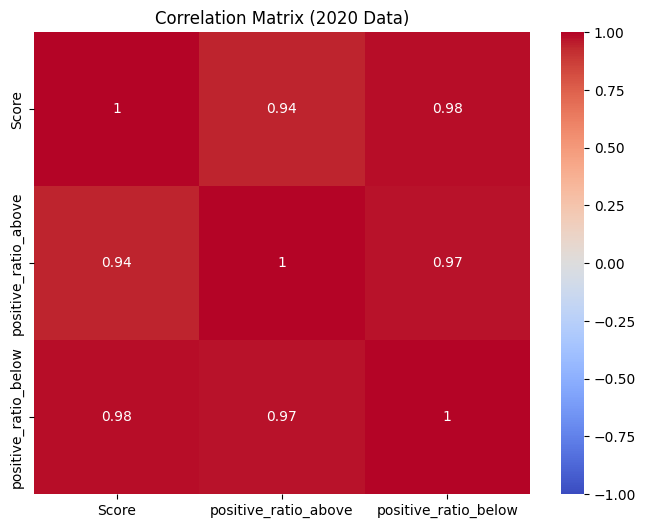

95% CI for correlation between Score vs positive_ratio_above: 0.918 to 0.955
95% CI for correlation between Score vs positive_ratio_below: 0.977 to 0.982
95% CI for correlation between positive_ratio_above vs positive_ratio_below: 0.962 to 0.980


In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example DataFrame
# df_2020_clean = pd.read_csv("your_data.csv")  # Use your data here

# Correlation matrix
corr_matrix = df_2020_clean[['Score', 'positive_ratio_above', 'positive_ratio_below']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (2020 Data)')
plt.show()

# Function to calculate bootstrapped confidence intervals
def bootstrap_corr_ci(data, col1, col2, n_bootstrap=1000, confidence=0.95):
    np.random.seed(42)  # For reproducibility
    bootstrapped_corrs = []

    for _ in range(n_bootstrap):
        # Resample data with replacement
        sample = data.sample(frac=1, replace=True)
        # Calculate correlation
        corr, _ = pearsonr(sample[col1], sample[col2])
        bootstrapped_corrs.append(corr)

    # Calculate confidence interval
    lower = np.percentile(bootstrapped_corrs, (1 - confidence) / 2 * 100)
    upper = np.percentile(bootstrapped_corrs, (1 + confidence) / 2 * 100)

    return lower, upper

# Example: Calculate confidence intervals
cols = ['Score', 'positive_ratio_above', 'positive_ratio_below']
ci_results = {}

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col1, col2 = cols[i], cols[j]
        lower_ci, upper_ci = bootstrap_corr_ci(df_2020_clean, col1, col2)
        ci_results[f'{col1} vs {col2}'] = (lower_ci, upper_ci)

# Print results
for pair, ci in ci_results.items():
    print(f"95% CI for correlation between {pair}: {ci[0]:.3f} to {ci[1]:.3f}")


## Distribution shift analysis
A comparison of the distribution of the two key variables namely, the input score and both outcome metrics (positive_ratio_above and positive_ratio_below) between 2013 and 2020 datasets

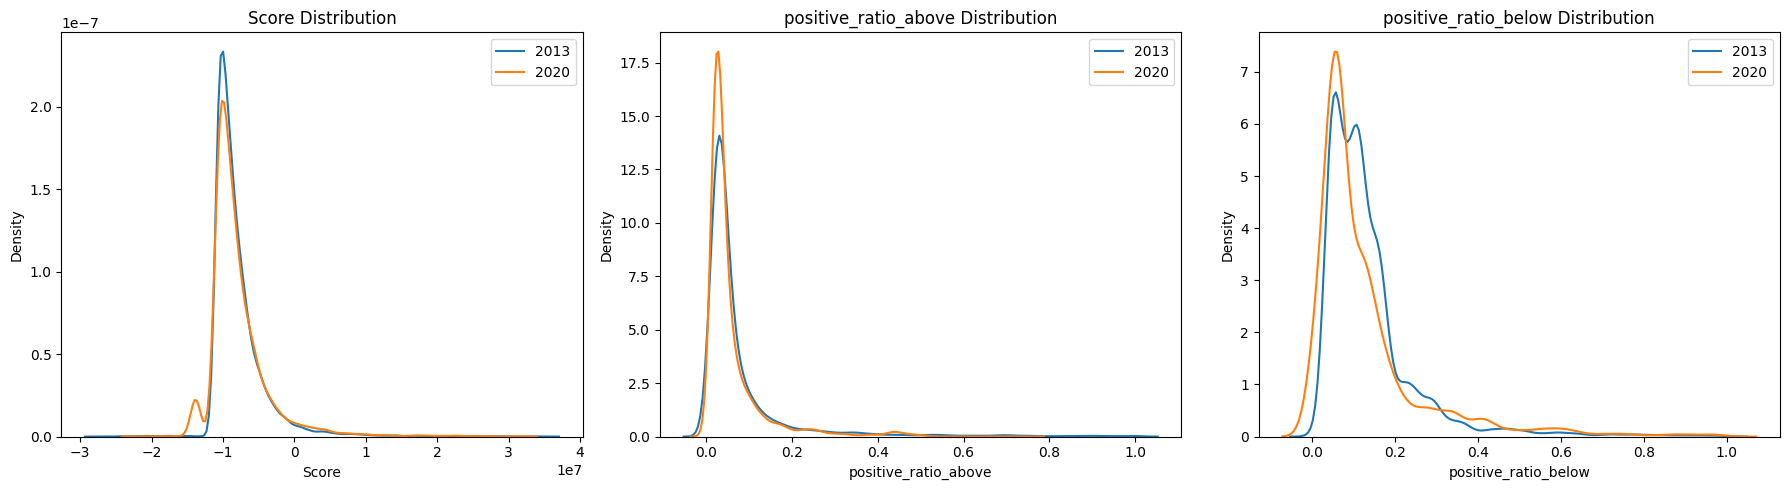

In [16]:

# 6. Year-to-Year Distribution Comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Score distribution
sns.kdeplot(df_2013_clean['Score'], ax=ax1, label='2013')
sns.kdeplot(df_2020_clean['Score'], ax=ax1, label='2020')
ax1.set_title('Score Distribution')
ax1.legend()


# positive_ratio_above distribution
sns.kdeplot(df_2013_clean['positive_ratio_above'], ax=ax2, label='2013')
sns.kdeplot(df_2020_clean['positive_ratio_above'], ax=ax2, label='2020')
ax2.set_title('positive_ratio_above Distribution')
ax2.legend()

# positive_ratio_below distribution
sns.kdeplot(df_2013_clean['positive_ratio_below'], ax=ax3, label='2013')
sns.kdeplot(df_2020_clean['positive_ratio_below'], ax=ax3, label='2020')
ax3.set_title('positive_ratio_below Distribution')
ax3.legend()

plt.tight_layout()
plt.savefig('KDE_plot.png')
plt.show()

## Saturation-guided review efficiency

we simulated a stopping rule based on predicted positive_ratio_below values. 

In our analysis, this threshold was set at 20%. Subsequently, we measured 

(i) the total number of records reviewed before reaching this point; and 

(ii) the total number of positive cases captured up to that point, relative to all positives in the dataset. 





**NOTE:This plot is only for Pytorch Neural Network model, please replace prediction_model variable with appropriate model name to results for that particular model**

In [17]:
prediction_model = 'PyTorch Neural Network'

# Define the threshold for stopping
threshold = 0.20

# Prepare a summary table
summary_rows = []

# Get the total number of positives in the 2020 clean set
total_positives = (df_2020_clean['Category2'] == 'positives').sum()
total_records = len(df_2020_clean)

# Ensure the test set is sorted by Score descending (as in your earlier code)
df_2020_clean_sorted = df_2020_clean.sort_values(by='Score', ascending=False).reset_index(drop=True)

# for name, model in trained_models.items():

# Predict positive_ratio_below for all records
X_test = df_2020_clean_sorted[['Score', 'positive_ratio_above']]
y_pred = trained_models[prediction_model].predict(X_test)

# Add predictions to the DataFrame
df_2020_clean_sorted['predicted_positive_ratio_below'] = y_pred

# Find the stopping index: first where predicted < threshold
stop_idx = (df_2020_clean_sorted['predicted_positive_ratio_below'] < threshold).idxmax()
if df_2020_clean_sorted['predicted_positive_ratio_below'].min() >= threshold:
    # If no prediction falls below threshold, review all records
    stop_idx = len(df_2020_clean_sorted) - 1

# Number of records reviewed (up to and including stop_idx)
n_reviewed = stop_idx + 1
pct_reviewed = n_reviewed / total_records * 100

# Number and percent of positives captured up to this point
positives_captured = (df_2020_clean_sorted.loc[:stop_idx, 'Category2'] == 'positives').sum()
pct_positives_captured = positives_captured / total_positives * 100
saved_annotations = total_records - n_reviewed
saved_annotations_percentage = (saved_annotations/total_records) * 100

summary_rows.append({
    'Model': prediction_model,
    'N reviewed records': n_reviewed,
    '% reviewed dataset': f"{pct_reviewed:.1f}%",
    'Positives captured': positives_captured,
    '% captured positives': f"{pct_positives_captured:.1f}%",
    'saved annotations' : saved_annotations,
    'saved_annotations_percentage' : f"{saved_annotations_percentage:.1f}%"
})

# Create and display the summary table
summary_df = pd.DataFrame(summary_rows)
summary_df

,Model,N reviewed records,% reviewed dataset,Positives captured,% captured positives,saved annotations,saved_annotations_percentage
0,PyTorch Neural Network,1268,16.6%,109,79.6%,6368,83.4%


### Saturation curve visualization. 

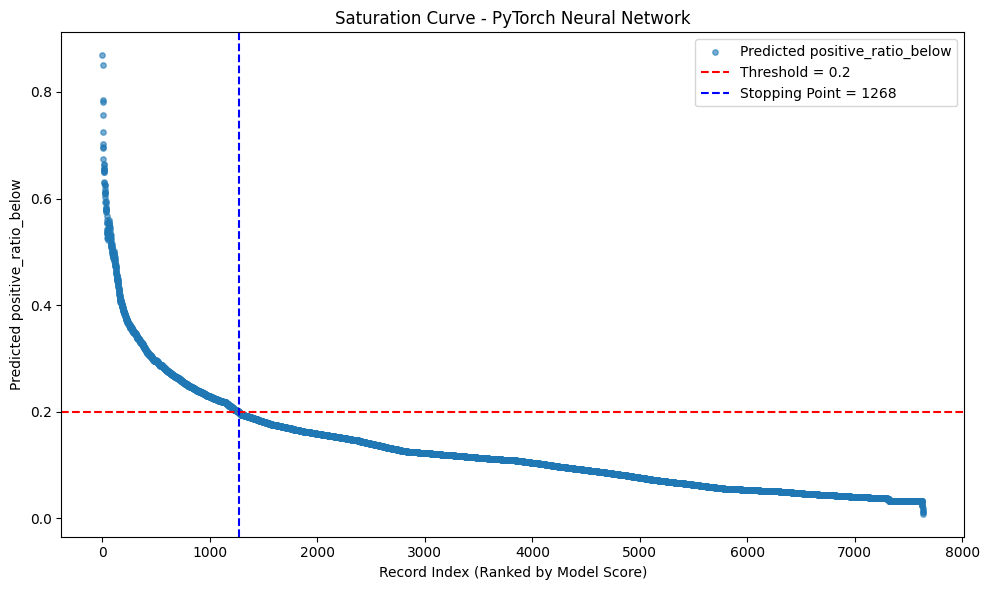

In [18]:
import matplotlib.pyplot as plt

# Choose the model to plot (e.g., 'PyTorch Neural Network')
model_name = 'PyTorch Neural Network'
model = trained_models[model_name]

# Predict on the sorted 2020 data
X_test = df_2020_clean_sorted[['Score', 'positive_ratio_above']]
y_pred = model.predict(X_test)

# Add predictions to DataFrame
df_2020_clean_sorted['predicted_positive_ratio_below'] = y_pred

# Find stopping index
threshold = 0.20
stop_idx = (df_2020_clean_sorted['predicted_positive_ratio_below'] < threshold).idxmax()
if df_2020_clean_sorted['predicted_positive_ratio_below'].min() >= threshold:
    stop_idx = len(df_2020_clean_sorted) - 1

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    range(len(df_2020_clean_sorted)),
    df_2020_clean_sorted['predicted_positive_ratio_below'],
    s=15, alpha=0.6, label='Predicted positive_ratio_below'
)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.axvline(x=stop_idx, color='blue', linestyle='--', label=f'Stopping Point = {stop_idx+1}')
plt.title(f'Saturation Curve - {model_name}')
plt.xlabel('Record Index (Ranked by Model Score)')
plt.ylabel('Predicted positive_ratio_below')
plt.legend()
plt.tight_layout()
plt.savefig('threshold_plot.png')
plt.show()